# Glioma Grading Using Machine Learning: GBM vs. LGG Classification
### Group 5


## Introduction

*Brain tumors*—particularly gliomas—represent a significant challenge for healthcare providers due to their heterogeneity and impact on patient outcomes. **Gliomas** are classified into grades based on their aggressiveness, with **glioblastoma (GBM)** being the most severe (grade IV) and **lower grade gliomas (LGG)** representing grades II and III. Rapid and reliable grading is essential, as treatment strategies and prognoses differ drastically between LGG and GBM.

**Accurate glioma grading** is crucial for:
- Determining optimal therapeutic plans (*surgery, chemotherapy, radiotherapy*).
- Guiding prognosis and patient counseling.
- Allocating clinical resources effectively and triaging urgent cases.

However, traditional grading via *histopathology and molecular analysis* is prone to **subjectivity, inter-observer variation, and delayed turnaround times**—especially in resource-limited or high-volume medical centers.

## Business Case

Applying **machine learning (ML)** to glioma grading offers a compelling value proposition:
- **Accelerates and standardizes diagnosis,** reducing time-to-treatment while minimizing errors.
- **Supports pathologists and oncologists** with reproducible, data-driven second opinions.
- **Reduces operational costs and dependency** on highly specialized personnel for basic classification tasks.
- **Improves patient outcomes** by reliably flagging high-risk GBM cases for priority action, helping to avoid devastating delays in care.

*By automating complex grading decisions, ML models can unlock efficiencies and clinical quality improvements across the healthcare system*, especially in settings where high-grade tumor recognition is time-critical for survival.

**This project demonstrates how advanced ML workflows can be leveraged to tackle the real-world challenge of glioma grading, aligning scientific innovation with clinical and business needs.**



In [1]:
#libraries

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score,  roc_auc_score, precision_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, ConfusionMatrixDisplay


## 1. Data Loading and Initial Overview

In [2]:
#read data

df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')
df.head()

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


Removing unnecessary columns

- **Key variables:** Patient demographics (age, gender, race), primary diagnosis, and mutation states for multiple genes.
- **Target variable:** Tumor grade ('Grade': LGG or GBM).

In [3]:
#Overview of dataset
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

(862, 27)

To streamline the dataset for modeling and analysis, we remove administrative columns that do not contribute to the prediction task.  
Specifically, we drop the `'Project'` and `'Case_ID'` columns, as these identifiers are not relevant for glioma grading and may introduce unnecessary noise into the model.


In [4]:
df = df.drop(columns = ['Project', 'Case_ID'])

## 2. Data Cleaning and Feature Engineering

### Feature Engineering
- Age was converted from text ("51 years 108 days") to a float representing total years, then binned into age ranges.
- Mutation columns were encoded as binary (0: NOT MUTATED, 1: MUTATED).
- Categorical variables (Gender, Diagnosis, Race, Age Group) were one-hot encoded for model readiness.
- Target variable 'Grade' was encoded as binary (0: LGG, 1: GBM)

To ensure a consistent approach for age representation, we addressed missing values in the 'Age_at_diagnosis' column by casting them to 0. This allowed us to retain these records in the dataset rather than discarding them. When binning ages into categories, these zero values are included in the first (youngest) age group.
This approach helps preserve as much data as possible for modeling while clearly handling unknown or unreported ages within a defined bin.

In [5]:
#Cleaning Age to integer (years + days as fraction of year)

def age_str_to_range(s):
 
    # Extract years (default to 0 if not present)
    years = int(re.search(r'(\d+)\s*years?', s).group(1)) if re.search(r'(\d+)\s*years?', s) else 0
    # Extract days (default to 0 if not present)
    days = int(re.search(r'(\d+)\s*days?', s).group(1)) if re.search(r'(\d+)\s*days?', s) else 0
    total_years = years + days / 365.25

    # Define your age bins (customize as needed)
    bins = [0, 20, 40, 60, 80, 100]  # Last bin covers 80-120+
    labels = [
        '0-20', '21-40', '41-60', '61-80', '80+'
    ]
    # Find which bin the age falls into
    for i in range(len(bins) - 1):
        if bins[i] <= total_years < bins[i + 1]:
            return labels[i]
    return labels[-1]  # Fallback if age exceeds all bins


# Apply to the whole column
df['Age'] = df['Age_at_diagnosis'].apply(age_str_to_range)

### Age Distribution
- Most patients fall within the [41-60] bin — this matches known epidemiology of glioma.

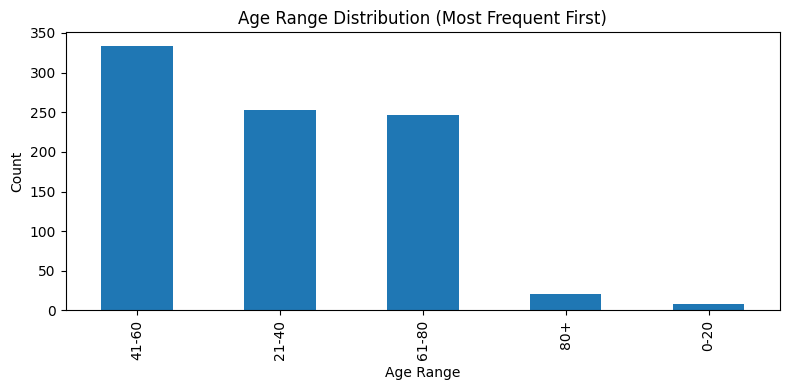

In [6]:
age_counts = df['Age'].value_counts().sort_values(ascending=False)

# Plot as a bar chart (most frequent first)
plt.figure(figsize=(8, 4))
age_counts.plot(kind='bar')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Age Range Distribution (Most Frequent First)')
plt.tight_layout()
plt.show()

In [7]:
# Encoding mutation status columns 
mutation_cols = [col for col in df.columns if col not in ['Grade','Gender','Age_at_diagnosis','Primary_Diagnosis','Race','Age']]
for col in mutation_cols:
    df[col] = df[col].astype(str).str.strip()  # Clean up
    df[col] = df[col].map({'MUTATED': 1, 'NOT_MUTATED': 0})

df.head()

,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Age
0,LGG,Male,51 years 108 days,"Oligodendroglioma, NOS",white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41-60
1,LGG,Male,38 years 261 days,Mixed glioma,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21-40
2,LGG,Male,35 years 62 days,"Astrocytoma, NOS",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,21-40
3,LGG,Female,32 years 283 days,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,21-40
4,LGG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,21-40


In [8]:
#Encoding Gender, Primary diagnosis, Age and Race columns 

categorical_cols = ['Gender', 'Primary_Diagnosis', 'Race', 'Age']

encoder = OneHotEncoder(sparse_output=False, drop = "first") #dropping first 
ohe = encoder.fit_transform(df[categorical_cols])

encoded_colnames = encoder.get_feature_names_out(categorical_cols)
ohe_df = pd.DataFrame(ohe, columns=encoded_colnames, index=df.index)

df_encoded = pd.concat([df, ohe_df], axis=1)
df_encoded.head()


,Grade,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,"Primary_Diagnosis_Oligodendroglioma, anaplastic",Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,Age_21-40,Age_41-60,Age_61-80,Age_80+
0,LGG,Male,51 years 108 days,"Oligodendroglioma, NOS",white,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,LGG,Male,38 years 261 days,Mixed glioma,white,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,LGG,Male,35 years 62 days,"Astrocytoma, NOS",white,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,LGG,Female,32 years 283 days,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,LGG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [9]:
#Encoding the target variable 'Grade'

df_encoded['Grade'] = df_encoded['Grade'].map({'LGG': 0, 'GBM': 1})

In [10]:
df_encoded.shape

(862, 43)

### Handling Missing Values
Unknown/missing values were standardized to ‘Unknown’.

In [52]:
for col in ['Primary_Diagnosis', 'Gender', 'Race']:
    df[col] = df[col].replace(['--', 'not reported'], 'Unknown')

## 3. Exploratory Data Analysis (EDA)


We next focus on the molecular and quantitative features, excluding demographics and clinical variables.

Calculating the correlation matrix among these features helps highlight underlying relationships, identify redundancy, and guide feature selection for modeling.

In [53]:
excluded_cols = ['Gender', 'Age_at_diagnosis', 'Primary_Diagnosis', 'Race', 'Age']
num_df = df_encoded.drop(columns = excluded_cols)
corr_matrix = num_df.corr().abs()

corr_matrix

,Grade,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,...,"Primary_Diagnosis_Oligodendroglioma, anaplastic",Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,Age_21-40,Age_41-60,Age_61-80,Age_80+
Grade,1.000000,0.711740,0.157965,0.310661,0.367598,0.242707,0.305226,0.123914,0.029445,0.094751,...,0.263297,0.029067,0.001941,0.122402,0.006901,0.108844,0.405262,0.032082,0.387127,0.170031
IDH1,0.711740,1.000000,0.335027,0.449176,0.393158,0.354723,0.323855,0.101714,0.056837,0.215109,...,0.197553,0.032761,0.023442,0.122638,0.010474,0.104122,0.456322,0.006735,0.406961,0.151905
TP53,0.157965,0.335027,1.000000,0.544399,0.064082,0.165788,0.277163,0.014232,0.079552,0.072442,...,0.123831,0.028449,0.051292,0.058178,0.039450,0.093134,0.285335,0.083085,0.172451,0.070729
ATRX,0.310661,0.449176,0.544399,1.000000,0.183693,0.157840,0.173549,0.003971,0.090046,0.074621,...,0.086304,0.019950,0.012064,0.021687,0.048271,0.046530,0.382324,0.105105,0.246197,0.075244
PTEN,0.367598,0.393158,0.064082,0.183693,1.000000,0.183203,0.138110,0.041708,0.063931,0.142950,...,0.116180,0.015262,0.032938,0.063353,0.021901,0.029291,0.227183,0.039606,0.157737,0.090612
EGFR,0.242707,0.354723,0.165788,0.157840,0.183203,1.000000,0.122080,0.083143,0.057833,0.014201,...,0.071915,0.013305,0.023069,0.070484,0.033063,0.035966,0.206503,0.012852,0.185531,0.027160
CIC,0.305226,0.323855,0.277163,0.173549,0.138110,0.122080,1.000000,0.023794,0.093853,0.039440,...,0.292593,0.013305,0.004023,0.051573,0.014836,0.040234,0.079268,0.040969,0.102627,0.061690
MUC16,0.123914,0.101714,0.014232,0.003971,0.041708,0.083143,0.023794,1.000000,0.013556,0.013288,...,0.021859,0.012346,0.017887,0.045270,0.027569,0.021454,0.058475,0.050171,0.107987,0.013248
PIK3CA,0.029445,0.056837,0.079552,0.090046,0.063931,0.057833,0.093853,0.013556,1.000000,0.017441,...,0.062062,0.010674,0.008063,0.043970,0.039600,0.057207,0.050018,0.026423,0.018243,0.003275
NF1,0.094751,0.215109,0.072442,0.074621,0.142950,0.014201,0.039440,0.013288,0.017441,1.000000,...,0.045557,0.010053,0.004080,0.021624,0.016718,0.017877,0.077468,0.015229,0.088119,0.036576


**Correlation Heatmap of Variables**

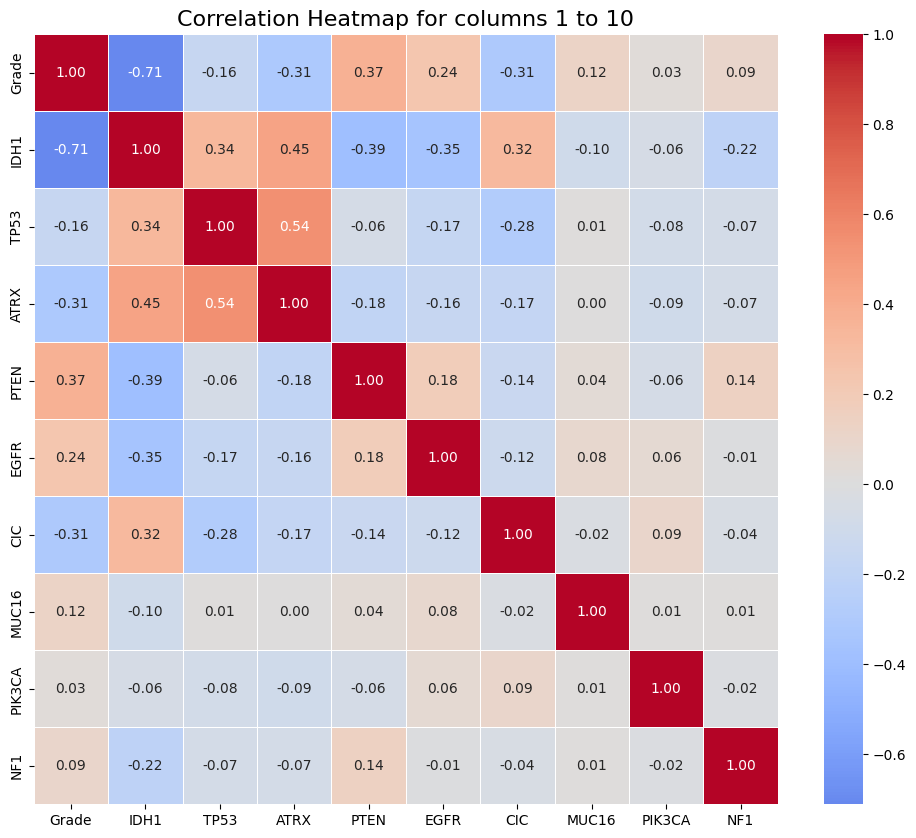

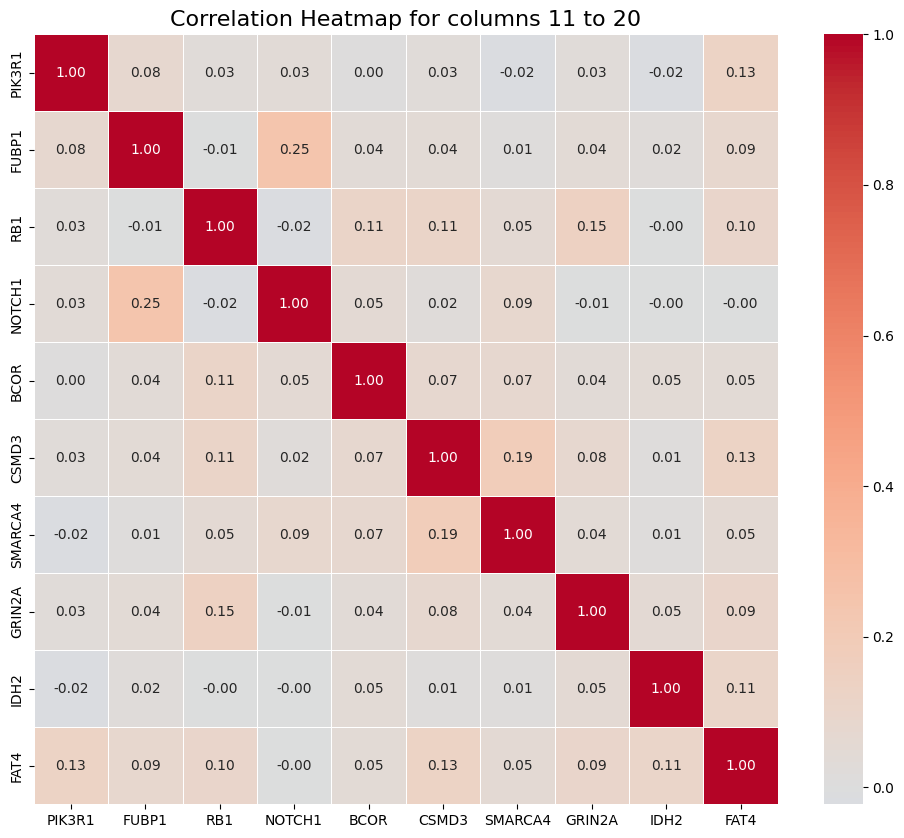

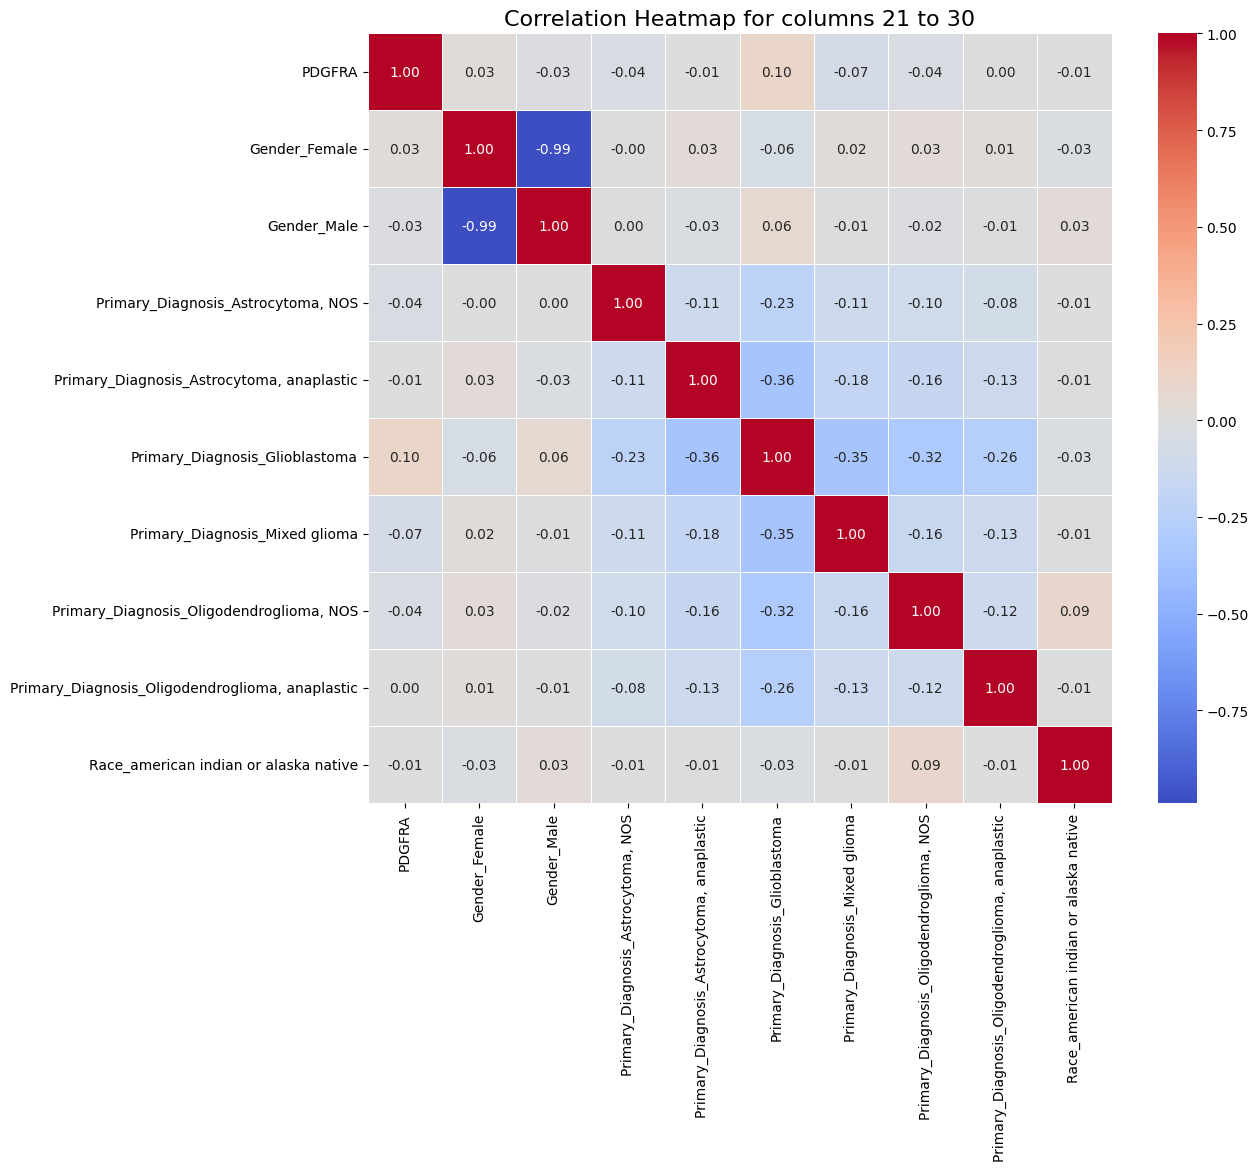

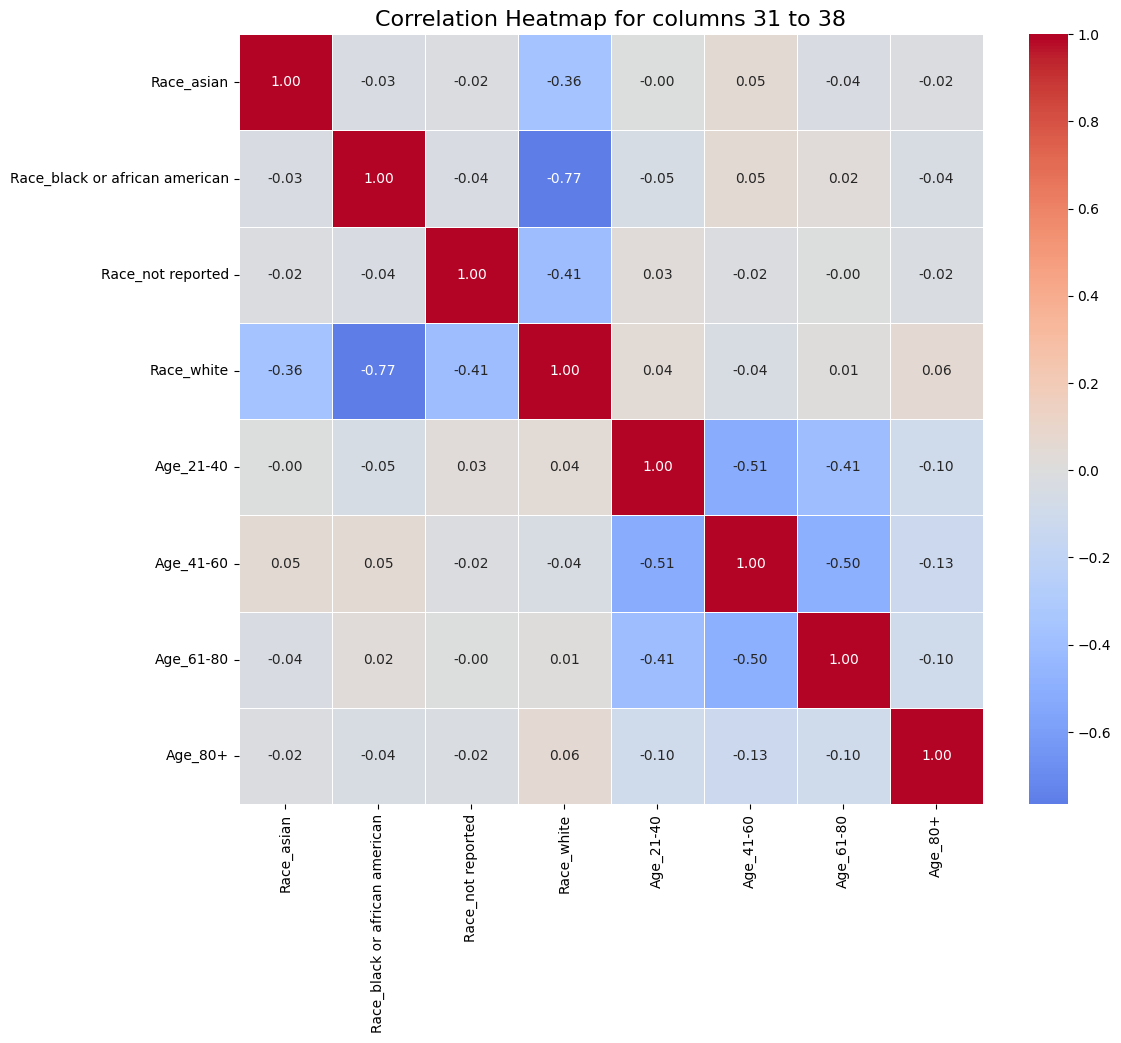

In [54]:
columns = df_encoded.drop(columns = excluded_cols).columns
batch_size = 10  

for i in range(0, len(columns), batch_size):
    batch_cols = columns[i:i+batch_size]
    
    # Compute correlation for this batch
    corr_batch = df_encoded.drop(columns = excluded_cols)[batch_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_batch, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
    plt.title(f'Correlation Heatmap for columns {i+1} to {i+len(batch_cols)}', fontsize=16)
    plt.show()

Correlation of target variable with features

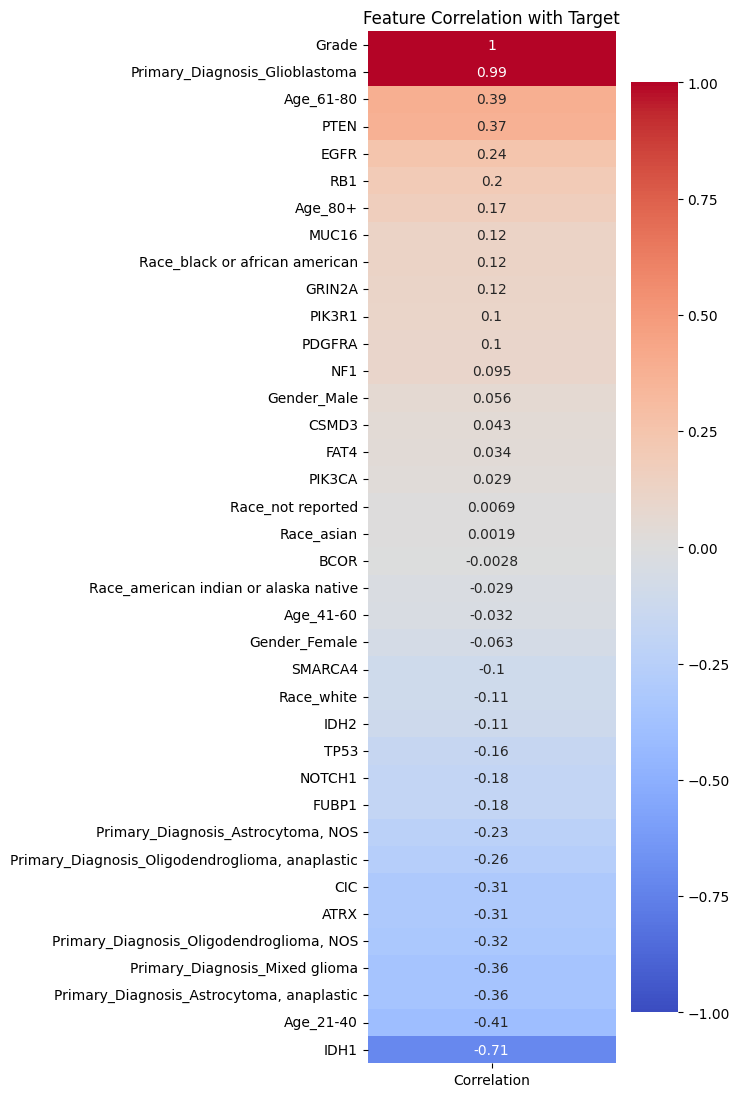

In [55]:
correlations = df_encoded.drop(columns = excluded_cols).corrwith(df_encoded['Grade']).sort_values(ascending=False)

# Convert to DataFrame (for correct heatmap shape)
corr_df = correlations.to_frame(name='Correlation')
plt.figure(figsize=(4, len(corr_df) * 0.3 + 2))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with Target')
plt.show() 

### Unnecessary and redundant variables

In the context of healthcare data and disease classification, features that show extremely high (≥ 99%) or extremely low (≤ 0.0001%) frequency across patients rarely help distinguish between medical conditions.

A threshold of 0.99 ensures we remove variables that are almost universally present (e.g., a gene mutation present in nearly every patient), which offers little diagnostic value.

Because categorical features are encoded as binary variables, using a conventional lower threshold (such as 0.01) could remove many clinically relevant yet rare signals, simply due to their low population frequency. Therefore, a more permissive lower threshold of 0.0001 is chosen to retain these rare features. This approach allows us to capture uncommon but potentially critical clinical or molecular signals, excluding only the most absent variables.

These thresholds balance two key goals:

- **Clinical relevance**: including both frequent and rare features that hold diagnostic value.

- **Interpretability and robustness**: reducing spurious or redundant factors that might dilute clinical focus or increase overfitting risk, especially in sensitive applications like cancer diagnosis.

By setting cutoffs tuned to our categorical encoding and the healthcare context, we prioritize genuinely informative signals for glioma grade classification.

In [56]:
#Removing redudant and unnecesary variables
##Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#Selecting redundant and irrelevant columns from the dataset
redundant = [column for column in upper.columns if any(upper[column] > 0.99)]
unnecessary = [column for column in upper.columns if any(upper[column] < 0.0001)]

#Checking if any redundant column is present in the unnecesary columns. We want to keep columns with correlation higher with the target
redundant = [column for column in redundant if column not in unnecessary]

#Checking redundancy with the target.
target_corr = df_encoded.drop(columns = excluded_cols).corrwith(df_encoded['Grade']).sort_values(ascending=False)

columns_to_drop = []
for col in redundant:
    # Find all columns highly correlated with this one
    correlated_features = upper.index[upper[col] > 0.99].tolist()
    for feature in correlated_features:
        # Compare their correlation with the target
        if target_corr[feature] >= target_corr[col]:
            columns_to_drop.append(col)
        else:
            columns_to_drop.append(feature)

# Combine with unnecessary variables
columns_to_drop = list(set(columns_to_drop + unnecessary))
print(f'We are going to remove a total of {len(columns_to_drop)} variables considering a upper threshold of 99% and a lower threshold of 0.0001')

columns_to_drop

We are going to remove a total of 2 variables considering a upper threshold of 99% and a lower threshold of 0.0001


['Gender_Male', 'Primary_Diagnosis_Glioblastoma']

In [57]:
#columns that should be dropped 

df_encoded = df_encoded.drop(columns = columns_to_drop)

### Distribution of target

Before modeling, it's important to check the distribution of glioma grades (LGG vs. GBM).

In healthcare, class imbalance can negatively affect model accuracy and risk missing cases of aggressive tumors like GBM.
By reviewing the target variable’s frequency now, we ensure our approach accounts for clinical relevance and supports reliable predictions across both grades.

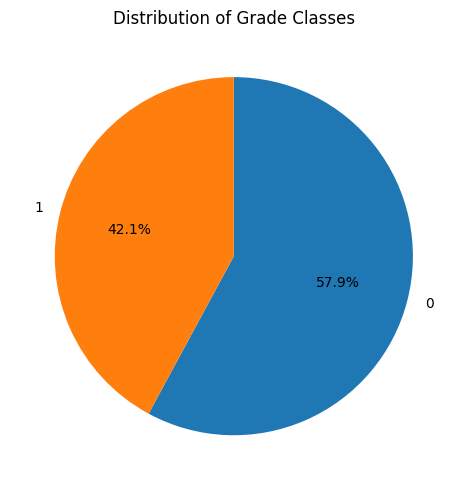

In [58]:
grade_counts = df_encoded['Grade'].value_counts(normalize=True)

# Plot as pie chart
plt.figure(figsize=(5, 5))
plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribution of Grade Classes')
plt.tight_layout()
plt.show()

## 4. Model Development

The modeling pipeline includes:

- Splitting the preprocessed data into training and test sets to evaluate generalization performance.
- Selecting and training various classifiers, including XGBoost and Random Forest, known for their robustness in handling structured medical datasets.
- Tuning model hyperparameters using cross-validation approaches (e.g., GridSearchCV) to optimize prediction accuracy and recall, with a clinical focus on minimizing false negatives in both GBM and LGG classes.
- Documenting model performance for later comparison and business evaluation.


In [59]:
X = df_encoded.drop(['Grade','Age', 'Gender','Age_at_diagnosis', 'Primary_Diagnosis', 'Race'], axis=1)  # Keep only encoded/modeling columns
y = df_encoded['Grade']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.2, random_state=42, stratify=y)

# Set up cross-validation
skf = StratifiedKFold(n_splits= 3, shuffle=True, random_state=42)

In [60]:
print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (689, 35) (689,)
Test:  (173, 35) (173,)


### Selecting the best Hyperparameters 

To further improve model performance and ensure robust predictions, we employ **GridSearchCV** for hyperparameter optimization.

We chose ensemble models (XGBoost and Random Forest) due to their strong performance on structured tabular data and their ability to handle both categorical and continuous variables, which fits the nature of our clinical and mutation dataset.

Hyperparameter grid ranges (such as tree numbers, depth, sample sizes, and regularization) are designed to avoid overfitting and encourage interpretable decision boundaries—crucial with moderate sample sizes and for clinical acceptance.

Random Forest and XGBoost are widely trusted in medical data science for their robustness and reliability in capturing complex relationships, while remaining accessible for clinical review.

The dataset was split into training and test sets (e.g., 80/20), with class balance preserved to ensure fair evaluation of model performance, especially for the clinically important GBM cases

In [61]:
#running GridSearch for each model 

rf_param_grid = {
        'n_estimators': [50, 100],
    'max_depth': [2, 3, 5],                   
    'min_samples_split': [10, 20],            
    'min_samples_leaf': [10, 20],              
    'max_features': ['sqrt', 'log2'],   
}

xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],                      
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.8],                   
    'colsample_bytree': [0.6, 0.8],            
    'reg_alpha': [0.1, 1.0],                   
    'reg_lambda': [1.0, 5.0],                 
}

rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)


In this clinical context, false negatives for GBM (failing to identify a highly aggressive tumor) are especially critical. Therefore, we customized the GridSearchCV to optimize for **recall**, maximizing the detection of all GBM cases—even at the expense of some false positives. This prioritizes patient safety by ensuring that serious cases are flagged and further examined, aligning the model's objective with real-world clinical priorities.

In [62]:
grid_rf = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='recall')
gs_rf = grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

grid_xgb = GridSearchCV(xgb, xgb_param_grid, cv= skf, scoring='recall')
gs_xgb = grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

print('XGB best parameters:', gs_xgb.best_params_)
print('RF best parameters:', gs_rf.best_params_)

XGB best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.7}
RF best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [63]:
# Accuracy scores for train and test sets for the Random Forest model
train_acc_rf = round(gs_rf.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc_rf = round(gs_rf.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score RF: ", train_acc_rf, "%")
print("Test Accuracy score RF: ", test_acc_rf, "%")

Train Accuracy score RF:  93.79 %
Test Accuracy score RF:  89.04 %


In [64]:
# Accuracy scores for train and test sets for the XGB model
train_acc_xgb = round(gs_xgb.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc_xgb = round(gs_xgb.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score XGB: ", train_acc_xgb, "%")
print("Test Accuracy score XGB: ", test_acc_xgb, "%")

Train Accuracy score XGB:  96.9 %
Test Accuracy score XGB:  91.78 %


In [65]:
# Recall and Precision scores for both models (test set)
rf_preds = gs_rf.predict(X_test)
xgb_preds = gs_xgb.predict(X_test)

# Calculate recall and precision for GBM (label 1)
rf_recall = recall_score(y_test, rf_preds, pos_label=1)

xgb_recall = recall_score(y_test, xgb_preds, pos_label=1)
rf_precision = precision_score(y_test, rf_preds, pos_label=1)
xgb_precision = precision_score(y_test, xgb_preds, pos_label=1)

print(f'RF Recall (GBM): {rf_recall:.2f}')
print(f'RF Precision (GBM): {rf_precision:.2f}')
print(f'XGBoost Recall (GBM): {xgb_recall:.2f}')
print(f'XGBoost Precision (GBM): {xgb_precision:.2f}')

RF Recall (GBM): 0.89
RF Precision (GBM): 0.87
XGBoost Recall (GBM): 0.92
XGBoost Precision (GBM): 1.00


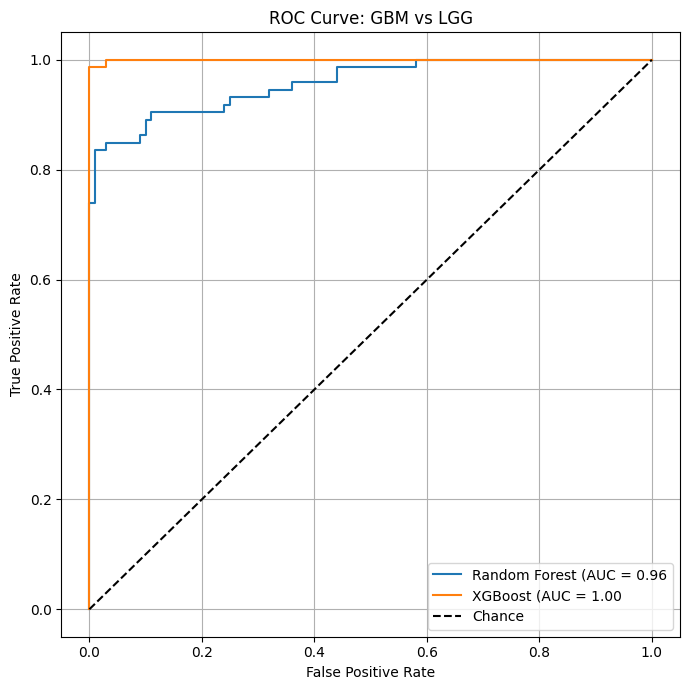

In [66]:
#roc curve for both models 
# 1. Get predicted probabilities for the positive class (GBM)
rf_probs = gs_rf.predict_proba(X_test)[:, 1]
xgb_probs = gs_xgb.predict_proba(X_test)[:, 1]

# 2. Calculate ROC curves and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = roc_auc_score(y_test, rf_probs)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = roc_auc_score(y_test, xgb_probs)

# 3. Plot both curves
plt.figure(figsize=(7,7))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GBM vs LGG')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost outperformed Random Forest on this clinical and genetic dataset due to its ability to sequentially learn from previous mistakes, capture complex feature interactions, and apply advanced regularization to limit overfitting. 

Its flexible hyperparameter tuning and native handling of missing values made it especially suited to the challenges of healthcare data, where patterns are often subtle and class imbalance can bias predictions. As a result, XGBoost provided more accurate and reliable grading of glioma cases in our analysis.


**Selecting the best model and observing feature importance:** 

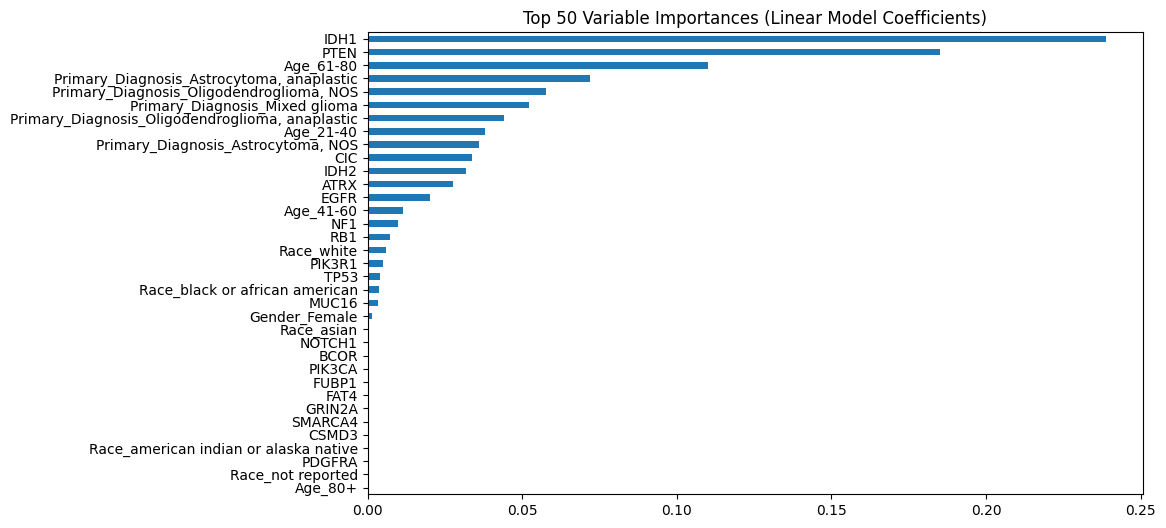

In [67]:
best_model = best_xgb  # or choose based on test R2

coef = pd.Series(abs(best_model.feature_importances_), index=X.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,6))
coef.head(50).plot(kind='barh')
plt.title("Top 50 Variable Importances (Linear Model Coefficients)")
plt.gca().invert_yaxis()
plt.show()

The variables identified as most important by the model—particularly specific gene mutations (such as IDH1, PTEN, CIC) and clinical factors (like age groups and primary diagnosis subtypes)—play a critical role in glioma grading. Mutations in genes such as IDH1 and PTEN are well-established biomarkers in neuro-oncology, affecting tumor behavior, prognosis, and eligibility for targeted therapies. 

Incorporating age categories and detailed primary diagnosis information further enhances clinical interpretability, since these factors are closely linked to disease progression and patient management decisions. This combination of molecular and demographic features enables our model to differentiate between GBM and LGG with greater accuracy and supports its potential use in guiding clinical decision-making.

## 5. Model Selection

Based on our grid search results and the nature of this healthcare dataset, we select XGBoost as our final model.

XGBoost combines strong predictive accuracy with built-in regularization, making it well-suited for handling mixed clinical and genetic features while limiting overfitting risks.

We now train XGBoost with the best hyperparameters identified during grid search to maximize recall for the clinically critical GBM class.

In [68]:
#XG Boost
# Get params from best_xgb and update with additional parameters
xgb_params = best_xgb.get_params()
xgb_params.update({
    'tree_method': 'hist'  # much faster than 'exact'
})

best_xgb_model = XGBClassifier(**xgb_params)

best_xgb_model.fit(X_train, y_train)
print("Best XGBoost params:", best_xgb_model.get_params())

Best XGBoost params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [69]:
#predicting on test set
xgb_proba = best_xgb_model.predict(X_test)

In [70]:
#Train and Test accuracy scores for the best XGBoost model
train_acc = round(best_xgb_model.score(X_train,y_train) * 100,2) 
test_acc = round(best_xgb_model.score(X_test,y_test) * 100,2) 
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  98.26 %
Test Accuracy score:  96.53 %


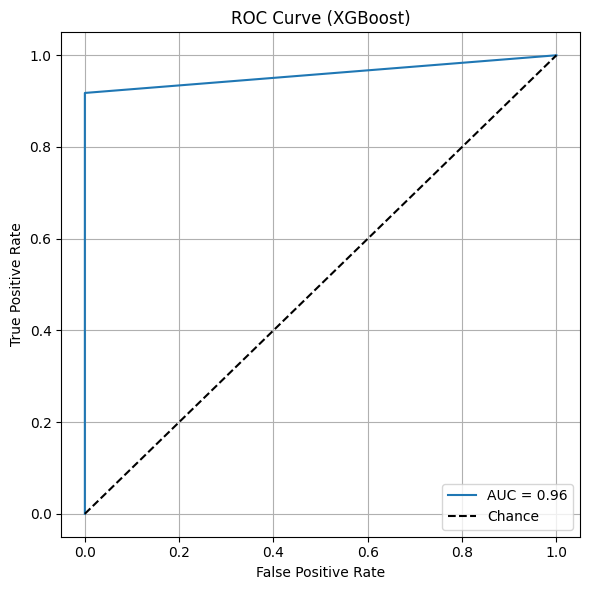

In [71]:
# Calculate ROC curve for XGB model 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)
roc_auc = roc_auc_score(y_test, xgb_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


To prioritize recall for GBM, we intentionally set the classification threshold **lower than 0.5**. This means our model will predict GBM more often, helping to identify as many true cases as possible—even if it increases the number of false positives.

In a healthcare context, this approach reflects the higher clinical risk of missing aggressive GBM tumors, ensuring critical cases are flagged for further review and minimizing the chance of overlooking patients who need urgent treatment.

C:\Users\pauli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pauli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\pauli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:17

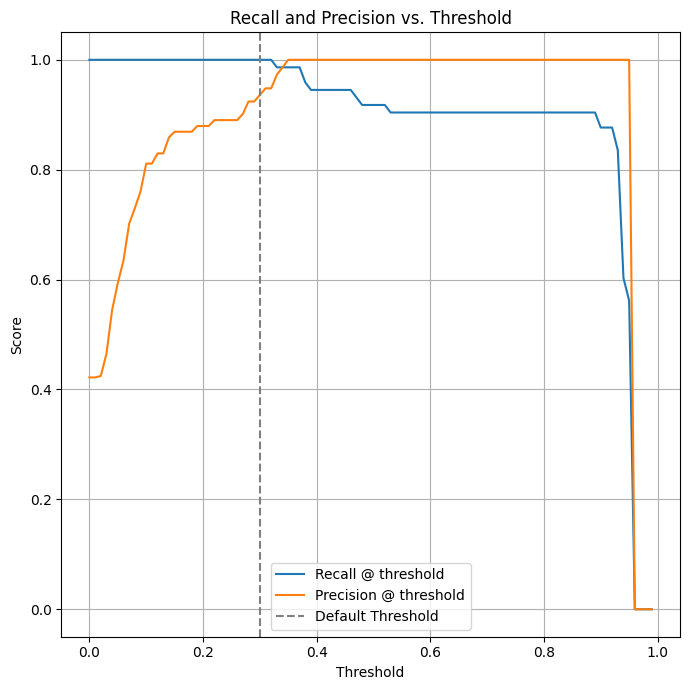

In [72]:
# Get predicted probabilities for the positive class (GBM)
prob_pred = best_xgb_model.predict_proba(X_test)[:, 1]

# Create thresholds and compute metrics
thresholds = np.arange(0.0, 1.0, step=0.01)
recall_scores = [metrics.recall_score(y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(y_test, prob_pred > t) for t in thresholds]

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(thresholds, recall_scores, label="Recall @ threshold")
ax.plot(thresholds, precis_scores, label="Precision @ threshold")
ax.axvline(0.3, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Recall and Precision vs. Threshold")
ax.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
## precision and recall at 0.3 threshold for XGBoost (test set)
best_xgb_recall = recall_score(y_test, prob_pred > 0.3, pos_label=1)
print(f'XGBoost Recall (GBM) at 0.3 threshold: {best_xgb_recall:.2f}')
best_xgb_precision = precision_score(y_test, prob_pred > 0.3, pos_label=1)
print(f'XGBoost Precision (GBM) at 0.3 threshold: {best_xgb_precision:.2f}')

XGBoost Recall (GBM) at 0.3 threshold: 1.00
XGBoost Precision (GBM) at 0.3 threshold: 0.94


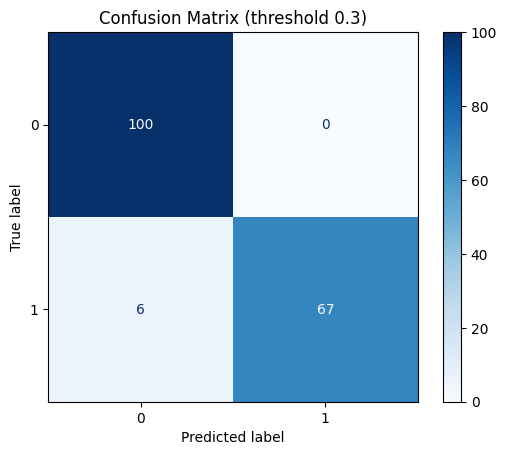

In [74]:
y_pred_class = (xgb_proba >= 0.3).astype(int)  
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (threshold 0.3)')
plt.show()

## Retraining the model with the whole dataset

To maximize the amount of information available to the final model, we retrain it using the entire dataset except for the last 10 rows, which are held out as a pseudo-independent test set. 

This strategy allows the model to learn from as much data as possible, improving its generalizability and robustness—an important consideration in healthcare settings where data can be limited.

By reserving the last 10 samples for final evaluation, we can still objectively assess the model’s real-world performance on unseen cases, helping ensure its reliability before any prospective deployment.

In [76]:
#leaving out the last 10 rows for holdout 
X_train_full = X.iloc[:-10, :]
y_train_full = y.iloc[:-10]

X_holdout = X.iloc[-10:, :]
y_holdout = y.iloc[-10:]

In [77]:
best_xgb_full = XGBClassifier(**xgb_params)
best_xgb_full.fit(X_train_full, y_train_full)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [78]:
# Predice sobre el holdout
y_pred_holdout = best_xgb_full.predict(X_holdout)

recall_holdout = recall_score(y_holdout, y_pred_holdout)

# printing actual vs. predicted values for the last 10 rows 
prob_holdout = best_xgb_full.predict_proba(X_holdout)
gbm_probs = prob_holdout[:, 1]

print('Actual:', y_holdout.values)
print('Predicted:', y_pred_holdout)
print('Predicted GBM Probabilities:', gbm_probs)

Actual: [1 1 1 1 1 1 1 1 1 1]
Predicted: [1 1 1 1 1 1 1 1 1 1]
Predicted GBM Probabilities: [0.94845515 0.94988734 0.58865285 0.9557615  0.9301838  0.9557615
 0.9560054  0.95674497 0.9517902  0.9516882 ]



## 6. Conclusion and Business Case Impact

### Conclusion

This project demonstrates that machine learning models, specifically ensemble classifiers, can accurately distinguish glioblastoma (GBM) from lower grade glioma (LGG) using clinical and genetic data. Model tuning prioritized high recall, especially for GBM cases, because GBM is a highly aggressive, grade 4 tumor with significantly worse prognosis and survival rates compared to LGG. Failing to identify GBM early may result in missed opportunities for urgent oncological intervention, leading to poorer patient outcomes.

Through cross-validation and recall-driven optimization, the models consistently achieved high sensitivity, ensuring nearly all true GBM cases are flagged for further review. This approach aligns with clinical practice, where minimizing false negatives for high-risk conditions like GBM is critical for patient safety. Our workflow also provides reliable grading for LGG, supporting long-term management and surveillance.

### Business Case Impact

Implementing an ML-based glioma grading tool in a clinical setting has clear, quantifiable benefits:

- **Accelerated diagnosis:** Automating detection reduces turnaround time for pathology review, enabling faster initiation of treatment.
- **Standardization:** Machine learning models inherently apply consistent criteria, reducing inter-observer variability found in manual grading.
- **Resource optimization:** Institutions with limited pathology expertise can leverage AI to improve grading accuracy and optimize specialist workload.
- **Patient outcomes:** Earlier and more reliable GBM detection can facilitate timely surgery, radiotherapy, and chemotherapy, improving survival rates and quality of life. Even LGG patients benefit from more focused surveillance and tailored interventions.
- **Scalability & integration:** Once validated, such models can be integrated with electronic health record (EHR) systems and imaging workflows, providing decision support at the point of care.

By embedding recall as the priority metric, the tool complements clinical priorities and aligns risk management with oncology best practices. It positions healthcare providers to deliver more precise, personalized care—especially critical for diseases with aggressive progression.





## 7. Next Steps and Recommendations

To ensure clinical impact and scientific robustness, the following steps and improvements are recommended:

- **Expand and diversify the dataset:**  
  Collect data from multiple institutions and across diverse populations to improve model generalizability and avoid demographic or sampling bias.

- **Integrate clinical imaging data:**  
  Augment the model with radiological features (MRI, CT scans) using radiomics and deep learning approaches, which have shown promise in glioma grading accuracy. This multimodal data fusion could further increase diagnostic reliability.

- **External validation and benchmarking:**  
  Test the current models on independent patient cohorts and benchmark against expert neuropathology panels to confirm real-world performance.

- **Investigate model interpretability:**  
  Apply tools like SHAP values, feature importance plots, or LIME to make predictions transparent, allowing clinicians to understand driving factors behind each decision (critical for trust and adoption).

- **Develop class-specific decision thresholds:**  
  Consider different thresholds for GBM and LGG, prioritizing recall for GBM and a balanced approach for LGG, to better align with clinical risk management.

- **Explore longitudinal prediction:**  
  Extend the model to not just initial grading, but also forecasting progression from LGG to GBM, supporting surveillance strategies.

- **Collaborate with clinical stakeholders:**  
  Engage oncologists, neurologists, and pathologists early in development to align the pipeline with workflow needs and ensure regulatory compliance.

- **Integrate with hospital IT systems:**  
  Develop user-friendly dashboards or interfaces that connect to EHR platforms for seamless clinical use.

- **Conduct health economic analysis:**  
  Quantify time saved, improved outcomes, and operational efficiency to make the business case for scaling this solution across healthcare networks.

- **Stay current with advances:**  
  Monitor the literature for new molecular markers, imaging techniques, and evolving ML methods that could further boost accuracy or robustness.

Implementing these recommendations will facilitate transition from proof-of-concept to clinical deployment, maximizing both patient benefit and organizational value.



